In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import pickle
import matplotlib.cm as cm
import seaborn as sns
from torchvision import transforms

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import sys
sys.path.append("../ProtoLearning/")
import data as data
import utils as utils
from models.icsn import iCSN

sys.path.append("../BaseVAEs/models/")
from disent.model.ae import EncoderConv64, DecoderConv64, AutoEncoder
from disent.frameworks.vae.weaklysupervised import AdaVae, AdaCatVae
from disent.frameworks.vae.unsupervised import BetaVae

In [2]:
def load_pretrained(model, ckpt):
    model.load_state_dict(ckpt['model'])
    model.proto_dict = ckpt['model_misc']['prototypes']
    model.softmax_temp = ckpt['model_misc']['softmax_temp']
    return model


def plot_single_img(model, imgs, idx):
    model.eval()
    preds, recons = model.forward_single(imgs)

    recons = recons.permute(0, 2, 3, 1).detach().cpu()
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    preds = preds.unsqueeze(dim=0).detach().cpu()
    preds = preds[0, idx]
    preds_as_ids = [torch.argmax(preds[model.attr_positions[i]:model.attr_positions[i+1]]).numpy() for i in range(model.n_groups)]

    # convert to RGB numpy array
    recons_np = recons[idx].squeeze().numpy()
    # convert -1 1 range to 0 255 range for plotting
    recons_np = ((recons_np - recons_np.min())
              * (1 / (recons_np.max() - recons_np.min()) * 255)).astype('uint8')
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    ax[0].imshow(imgs[idx])
    ax[0].axis('off')
    ax[0].set_title("Input Img");
    ax[1].imshow(preds.unsqueeze(dim=0), cmap=cm.gray)
    ax[1].axes.yaxis.set_visible(False)
    ax[1].set_title("I believe it has these properties");
#     ax[1].set_xlabel("Attributes");
    ax[2].imshow(recons_np)
    ax[2].axis('off')
    ax[2].set_title("Because it is close to these composed prototypes:");
    plt.show()
    
    return fig, preds_as_ids


### Create a dictionary to convert a label list of individual groups to a single id

In [3]:
convert_multilabel_to_label_id = {}
id = 0
for i in range(4):
    for j in range(4):
        for k in range(2):
            convert_multilabel_to_label_id[f'{i}{j}{k}'] = id
            id+=1

### Get training and validation set containing old and new objects for linear probing

In [4]:
# train data set
train_probing_data_path = f"../Data/ECR/train_probing/train_probing_ecr.npy"
train_probing_labels_path = f"../Data/ECR/train_probing/train_probing_ecr_labels.pkl"

train_probing_imgs = np.load(train_probing_data_path, allow_pickle=True)
train_probing_imgs = (train_probing_imgs - train_probing_imgs.min()) / (train_probing_imgs.max() - train_probing_imgs.min())

with open(train_probing_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    train_probing_labels = labels_dict['labels']
  
train_probing_imgs = torch.tensor(np.moveaxis(train_probing_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
train_probing_imgs = train_probing_imgs.type('torch.FloatTensor')
train_probing_labels = torch.tensor(train_probing_labels)    

# convert multi label to single label
train_probing_labels = train_probing_labels.int()
# single_train_probing_labels = torch.tensor([convert_multilabel_to_label_id[f'{train_probing_labels[i][0].item()}{train_probing_labels[i][1].item()}{train_probing_labels[i][2].item()}'] for i in range(train_probing_labels.shape[0])])

train_probing_dataset = torch.utils.data.TensorDataset(train_probing_imgs, train_probing_labels)
train_probing_dataloader = torch.utils.data.DataLoader(train_probing_dataset, batch_size=len(train_probing_dataset),
                                                  shuffle=True)

# val data set
val_data_path = f"../Data/ECR/val_ecr.npy"
val_labels_path = f"../Data/ECR/val_ecr_labels.pkl"

val_imgs = np.load(val_data_path, allow_pickle=True)
val_imgs = (val_imgs - val_imgs.min()) / (val_imgs.max() - val_imgs.min())

with open(val_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    val_labels = labels_dict['labels']
  
val_imgs = torch.tensor(np.moveaxis(val_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
val_imgs = val_imgs.type('torch.FloatTensor')
val_labels = torch.tensor(val_labels)    

# convert multi label to single label
val_labels = val_labels.int()
# single_val_labels = torch.tensor([convert_multilabel_to_label_id[f'{val_labels[i][0].item()}{val_labels[i][1].item()}{val_labels[i][2].item()}'] for i in range(val_labels.shape[0])])

val_dataset = torch.utils.data.TensorDataset(val_imgs, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset),
                                                  shuffle=True)

# get data from loader
train_probing_imgs, train_probing_label_ids = next(iter(train_probing_dataloader))
val_imgs, val_label_ids = next(iter(val_dataloader))

# convert multilabel to single label
train_probing_single_labels = torch.tensor([convert_multilabel_to_label_id[
    f'{train_probing_label_ids[i][0].item()}{train_probing_label_ids[i][1].item()}{train_probing_label_ids[i][2].item()}'] for i in range(train_probing_label_ids.shape[0])])
val_single_labels = torch.tensor([convert_multilabel_to_label_id[
    f'{val_label_ids[i][0].item()}{val_label_ids[i][1].item()}{val_label_ids[i][2].item()}'] for i in range(val_label_ids.shape[0])])

### Variance calculation for Proto-Swap-AE

In [5]:
def compute_code_and_variance(model, imgs, gt_labels_ids, config):
    collect_codes = {}

    try:
        codes, _ = model.forward_single(imgs)
    except:
        _, codes = model.forward(imgs)
        codes = codes.squeeze(dim=2)

    # for every GT attribute collect the codes from each model and data set
    for cat_id in range(0, 3):
        
        for concept_id in range(0, 4):
        
            # find those samples that have the same concept in the specified category identifier
            rel_ids = torch.where(gt_labels_ids.T[cat_id] == concept_id)[0]
            
            # filter out the model code for those samples in the specified category identifier
            try:
                rel_codes = codes[rel_ids, 
                                   config['prototype_cumsum'][cat_id]:config['prototype_cumsum'][cat_id+1]]
            except:
                rel_codes = codes[rel_ids, cat_id]
            
            # store the individual codes
            collect_codes[f"{str(cat_id)}-{str(concept_id)}"] = rel_codes.detach().cpu()

    collect_variance = {}

    sum_variance = 0.

    # iterate over each GT attribute and compute the code variance at the relevant factor id
    for cat_id in range(0, 3):
    
        for concept_id in range(0, 4):
            
            var = torch.sum(torch.var(collect_codes[f"{str(cat_id)}-{str(concept_id)}"], dim=0))

            if not torch.isnan(var):
            
                collect_variance[f"{str(cat_id)}-{str(concept_id)}"] = var
                
                sum_variance += var
                 
    sum_variance /= len(collect_variance.keys())
    
    print(sum_variance)

    return {'codes': codes, 'collect_codes': collect_codes, 
                                  'variances': collect_variance, 'avg_variance': sum_variance}

icsn_results_all = {}
# load models without additional feedback
for model_id in [0, 1, 3, 13, 21]:    
    ckpt_fp = f"../ProtoLearning/runs/icsn-{model_id}-ecr/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    icsn_model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    icsn_model = icsn_model.to(config['device'])
    icsn_model = load_pretrained(icsn_model, ckpt)
    icsn_model.temperature = 0.000001
    icsn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=icsn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=icsn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    icsn_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}


icsn_rr_results_all = {}
# load models with additional feedback
for model_id in [0, 1, 3, 13, 21]:    
    if model_id == 0 or model_id == 13:
        ckpt_fp = f"../ProtoLearning/runs/icsn-rr2-{model_id}-ecr/states/00199.pth"
    else:
        ckpt_fp = f"../ProtoLearning/runs/icsn-rr-{model_id}-ecr/states/00199.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    icsn_rr_model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], enc_size=config['enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    icsn_rr_model = icsn_rr_model.to(config['device'])
    icsn_rr_model = load_pretrained(icsn_rr_model, ckpt)
    icsn_rr_model.temperature = 0.000001
    icsn_rr_model.eval();

    train_result_dict = compute_code_and_variance(model=icsn_rr_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=icsn_rr_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    icsn_rr_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}


# VAE with adaptive id identification
adavae_orig_results_all = {}
for model_id in [0, 1, 3, 13, 21]:    
    ckpt_fp = f"../BaseVAEs/runs/adaid-orig-vae-{model_id}-ecr/states/01999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    adavae_orig_model = AdaVae(make_optimizer_fn=lambda params: Adam(params, lr=1e-3),
             make_model_fn=lambda: AutoEncoder(
                 encoder=EncoderConv64(x_shape=(3, 64, 64), z_size=3, z_multiplier=2),
                 decoder=DecoderConv64(x_shape=(3, 64, 64), z_size=3),
             ),
             cfg=AdaVae.cfg(beta=1, average_mode='gvae', symmetric_kl=False))

    adavae_orig_model = adavae_orig_model.to(config['device'])
    adavae_orig_model.load_state_dict(ckpt['model'])
    adavae_orig_model.eval();

    train_result_dict = compute_code_and_variance(model=adavae_orig_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=adavae_orig_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    adavae_orig_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}
    

# VAE with match pairing
adavae_results_all = {}
for model_id in [0, 1, 3, 13, 21]:    
    ckpt_fp = f"../BaseVAEs/runs/adaid-vae-{model_id}-ecr-beta4/states/01999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    adavae_model = AdaVae(make_optimizer_fn=lambda params: Adam(params, lr=1e-3),
             make_model_fn=lambda: AutoEncoder(
                 encoder=EncoderConv64(x_shape=(3, 64, 64), z_size=3, z_multiplier=2),
                 decoder=DecoderConv64(x_shape=(3, 64, 64), z_size=3),
             ),
             cfg=AdaVae.cfg(beta=1, average_mode='gvae', symmetric_kl=False))

    adavae_model = adavae_model.to(config['device'])
    adavae_model.load_state_dict(ckpt['model'])
    adavae_model.eval();

    train_result_dict = compute_code_and_variance(model=adavae_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=adavae_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    adavae_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}
    

catvae_results_all = {}
for model_id in [0, 1, 3, 13, 21]:        
    ckpt_fp = f"../BaseVAEs/runs/adaid-catvae-{model_id}-ecr/states/01999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    catvae_model = AdaCatVae(make_optimizer_fn=lambda params: Adam(params, lr=1e-3),
                       make_model_fn=lambda: AutoEncoder(
                           encoder=EncoderConv64(x_shape=(3, 64, 64), z_size=18),
                           decoder=DecoderConv64(x_shape=(3, 64, 64), z_size=18),
                       ),
                       cfg=AdaCatVae.cfg(beta=4, n_categories=config['n_protos'],
                                         n_variables=config['n_groups'],
                                         temp=config['temperature'], eps=1e-12, z_size=18,
                                         average_mode='gvae', symmetric_kl=False)
                       )

    catvae_model = catvae_model.to(config['device'])
    catvae_model.load_state_dict(ckpt['model'])
    catvae_model.eval();

    train_result_dict = compute_code_and_variance(model=catvae_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=catvae_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    catvae_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    
betavae_results_all = {}
for model_id in [0, 1, 3, 13, 21]:        
    ckpt_fp = f"../BaseVAEs/runs/unsup-betavae-{model_id}-ecr/states/01999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=torch.device('cpu'))
    config = ckpt['config']
    config['device'] = 'cpu'
    config['data_dir'] = '../Data/ECR/'

    betavae_model = BetaVae(make_optimizer_fn=lambda params: Adam(params, lr=1e-3),
                 make_model_fn=lambda: AutoEncoder(
                     encoder=EncoderConv64(x_shape=(3, 64, 64), z_size=config['n_groups'], z_multiplier=2),
                     decoder=DecoderConv64(x_shape=(3, 64, 64), z_size=config['n_groups']),
                 ),
                 cfg=BetaVae.cfg(beta=4))

    betavae_model = betavae_model.to(config['device'])
    betavae_model.load_state_dict(ckpt['model'])
    betavae_model.eval();

    train_result_dict = compute_code_and_variance(model=betavae_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=betavae_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    betavae_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

Loading model ../WeakAEProtoLearning/runs/ae-swap-priorknowledge-0-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../WeakAEProtoLearning/runs/ae-swap-priorknowledge-1-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../WeakAEProtoLearning/runs/ae-swap-priorknowledge-3-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../WeakAEProtoLearning/runs/ae-swap-priorknowledge-13-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.0490)
tensor(0.0491)
Loading model ../WeakAEProtoLearning/runs/ae-swap-priorknowledge-21-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.0497)
tensor(0.0501)
Loading model ../WeakAEProtoLearning/runs/ae-swap-0-simpleshapescolorvarshapesizepairsmult-nopretrain-trainprotos/states/07999.pth
tensor(0.04

In [6]:
def fit_and_predict_lr_dt(results_dict, gt_single_labels_val, model_seed_id, verbose=0):

    codes_train = results_dict[model_seed_id]['train']['codes']
    codes_val = results_dict[model_seed_id]['val']['codes']

    # decision tree
    clf_dt = DecisionTreeClassifier(random_state=21, max_depth=8)
    clf_dt.fit(codes_train.detach().cpu().numpy(), train_probing_single_labels.numpy())

    # Perform logistic regression
    clf_lr = LogisticRegression(random_state=0, C=0.316, max_iter=1000)
    clf_lr.fit(codes_train.detach().cpu().numpy(), train_probing_single_labels.numpy())

    # Evaluate using the classifiers
    predictions_dt = clf_dt.predict(codes_val.detach().cpu().numpy())
    predictions_lr = clf_lr.predict(codes_val.detach().cpu().numpy())

    accuracy_dt = np.mean((gt_single_labels_val.numpy() == predictions_dt).astype(np.float)) * 100.
    accuracy_lr = np.mean((gt_single_labels_val.numpy() == predictions_lr).astype(np.float)) * 100.

    if verbose > 0:
        print(f"\nSeed {model_seed_id} Val accuracy DT codes = {accuracy_dt:.3f}")
        print(f"Seed {model_seed_id} Val accuracy LR codes = {accuracy_lr:.3f}")
    return accuracy_dt, accuracy_lr

print('------------------------------------------------------')
print('iCSN before feedback')
acc_icsn_dt = []
acc_icsn_lr = []
code_vars_icsn_val = []
for seed_id in [0, 1, 3, 13, 21]:
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=icsn_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_icsn_dt.append(accuracy_dt)
    acc_icsn_lr.append(accuracy_lr)

    code_vars_icsn_val.append(icsn_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('iCSN with feedback')
acc_icsn_rr_dt = []
acc_icsn_rr_lr = []
code_vars_icsn_rr_val = []
for seed_id in [0, 1, 3, 13, 21]:
# for seed_id in [0, 1, 13, 21]:
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=icsn_rr_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_icsn_rr_dt.append(accuracy_dt)
    acc_icsn_rr_lr.append(accuracy_lr)
    
    code_vars_icsn_rr_val.append(icsn_rr_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('Orig AdaVAE')
acc_orig_adavae_dt = []
acc_orig_adavae_lr = []
code_vars_orig_adavae_val = []
for seed_id in [0, 1, 3, 13, 21]:
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=adavae_orig_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_orig_adavae_dt.append(accuracy_dt)
    acc_orig_adavae_lr.append(accuracy_lr)
    
    code_vars_orig_adavae_val.append(adavae_orig_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('AdaVAE')
acc_adavae_dt = []
acc_adavae_lr = []
code_vars_adavae_val = []
for seed_id in [0, 1, 3, 13, 21]:
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=adavae_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_adavae_dt.append(accuracy_dt)
    acc_adavae_lr.append(accuracy_lr)
    
    code_vars_adavae_val.append(adavae_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('CatVAE')
acc_catvae_dt = []
acc_catvae_lr = []
code_vars_catvae_val = []
for seed_id in [0, 1, 3, 13, 21]:
# for seed_id in [0, 1, 3, 13]:
    
    # convert arrays of each factor to single array
    catvae_results_all[seed_id]['train']['codes'] = catvae_results_all[seed_id]['train']['codes'].view(-1, 18)
    catvae_results_all[seed_id]['val']['codes'] = catvae_results_all[seed_id]['val']['codes'].view(-1, 18)
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=catvae_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_catvae_dt.append(accuracy_dt)
    acc_catvae_lr.append(accuracy_lr)

    code_vars_catvae_val.append(catvae_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('BetaVAE')
acc_betavae_dt = []
acc_betavae_lr = []
code_vars_betavae_val = []
for seed_id in [0, 1, 3, 13, 21]:
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=betavae_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=seed_id)
    acc_betavae_dt.append(accuracy_dt)
    acc_betavae_lr.append(accuracy_lr)
    
    code_vars_betavae_val.append(betavae_results_all[seed_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('------------------------Mean--------------------------')
print('------------------------------------------------------')
print(f"Mean acc. iCSN\nDT: {np.mean(acc_icsn_dt)} {np.std(acc_icsn_dt)}"+
      f"\nLR:  {np.mean(acc_icsn_lr)} {np.std(acc_icsn_lr)}\n")
print(f"Mean acc. iCSN w. feedback\nDT: {np.mean(acc_icsn_rr_dt)} {np.std(acc_icsn_rr_dt)}"+
      f"\nLR:  {np.mean(acc_icsn_rr_lr)} {np.std(acc_icsn_rr_lr)}\n")
print(f"Mean acc. Ada-VAE Orig\nDT: {np.mean(acc_orig_adavae_dt)} {np.std(acc_orig_adavae_dt)}"+
      f"\nLR:  {np.mean(acc_orig_adavae_lr)} {np.std(acc_orig_adavae_lr)}\n")
print(f"Mean acc. Ada-VAE\nDT: {np.mean(acc_adavae_dt)} {np.std(acc_adavae_dt)}"+
      f"\nLR:  {np.mean(acc_adavae_lr)} {np.std(acc_adavae_lr)}\n")
print(f"Mean acc. CatVAE\nDT: {np.mean(acc_catvae_dt)} {np.std(acc_catvae_dt)}"+
      f"\nLR:  {np.mean(acc_catvae_lr)} {np.std(acc_catvae_lr)}\n")
print(f"Mean acc. BetaVAE\nDT: {np.mean(acc_betavae_dt)} {np.std(acc_betavae_dt)}"+
      f"\nLR:  {np.mean(acc_betavae_lr)} {np.std(acc_betavae_lr)}\n")

print('------------------------------------------------------')
print('----------------------Median--------------------------')
print('------------------------------------------------------')
print(f"Median acc. iCSN\nDT: {np.median(acc_icsn_dt)} {np.std(acc_icsn_dt)}"+
      f"\nLR:  {np.median(acc_icsn_lr)} {np.std(acc_icsn_lr)}\n")
print(f"Median acc. iCSN w. feedback\nDT: {np.median(acc_icsn_rr_dt)} {np.std(acc_icsn_rr_dt)}"+
      f"\nLR:  {np.median(acc_icsn_rr_lr)} {np.std(acc_icsn_rr_lr)}\n")
print(f"Median acc. Ada-VAE Orig\nDT: {np.median(acc_orig_adavae_dt)} {np.std(acc_orig_adavae_dt)}"+
      f"\nLR:  {np.median(acc_orig_adavae_lr)} {np.std(acc_orig_adavae_lr)}\n")
print(f"Median acc. Ada-VAE\nDT: {np.median(acc_adavae_dt)} {np.std(acc_adavae_dt)}"+
      f"\nLR:  {np.median(acc_adavae_lr)} {np.std(acc_adavae_lr)}\n")
print(f"Median acc. CatVAE\nDT: {np.median(acc_catvae_dt)} {np.std(acc_catvae_dt)}"+
      f"\nLR:  {np.median(acc_catvae_lr)} {np.std(acc_catvae_lr)}\n")
print(f"Median acc. BetaVAE\nDT: {np.median(acc_betavae_dt)} {np.std(acc_betavae_dt)}"+
      f"\nLR:  {np.median(acc_betavae_lr)} {np.std(acc_betavae_lr)}\n")

------------------------------------------------------
iCSN with prior knowledge
------------------------------------------------------
iCSN before feedback
------------------------------------------------------
iCSN with feedback
------------------------------------------------------
iCSN with averaging
------------------------------------------------------
Orig AdaVAE
------------------------------------------------------
AdaVAE
------------------------------------------------------
CatVAE
------------------------------------------------------
CatVAE with swapping
------------------------------------------------------
BetaVAE
------------------------------------------------------
------------------------Mean--------------------------
------------------------------------------------------
Mean acc. iCSN with priorknowledge
DT: 82.4 18.643712076729788
LR:  82.4 18.643712076729788

Mean acc. iCSN
DT: 99.92 0.050990195135924954
LR:  99.87 0.07483314773547989

Mean acc. iCSN w. feedback
D

### Plot code variance

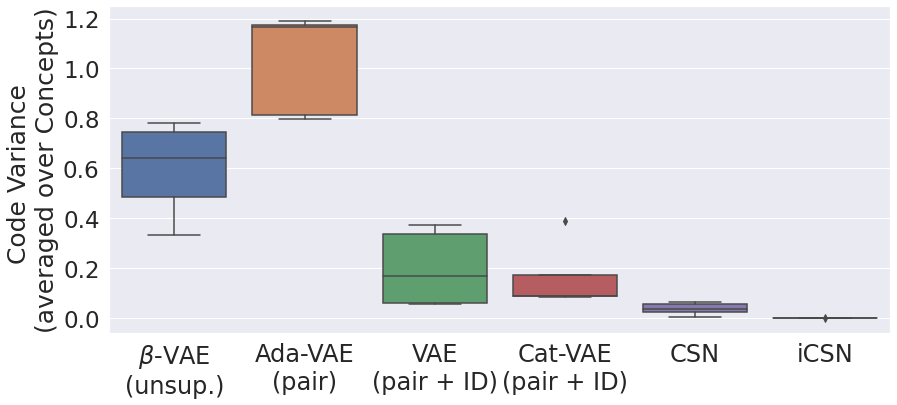

In [7]:
sns.set()
from matplotlib import rc
rc('font',**{'family':'serif','serif':['DejaVu Sans']})
fig, ax = plt.subplots(figsize=(14, 6))
ax.tick_params(axis='both', which='major', labelsize=23)
ax.tick_params(axis='both', which='minor', labelsize=23)
sns.boxplot(data=[code_vars_betavae_val, code_vars_orig_adavae_val, code_vars_adavae_val, code_vars_catvae_val, 
                  code_vars_icsn_val, code_vars_icsn_rr_val])
ax.set_xticklabels([r"$\beta$-VAE"+"\n(unsup.)", "Ada-VAE\n(pair)", "VAE\n(pair + ID)", 
                    "Cat-VAE\n(pair + ID)", "CSN", "iCSN"], fontsize=24, rotation=0)
ax.set_ylabel("Code Variance \n(averaged over Concepts)", fontsize=25)
# ax.set_title("Average Latent Code Variance", fontsize=26)

fig.savefig("code_variance.pdf", bbox_inches='tight')
plt.show()


